In [1]:
import pandas as pd
import plotnine as p9
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from textwrap import wrap
import sys
sys.path.append("../")

from k8s_survey_analysis.plot_utils import (
    make_likert_chart_multi_year,
    make_bar_chart_multi_year
)

from k8s_survey_analysis import prepare_2019, prepare_2018

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
# Match Field Names and Multiple Choice Options as much as possible
df_2019 = prepare_2019.get_df('../2019/contribex-survey-2019.csv').assign(year=2019)
df_2018 = prepare_2018.get_df('../2018/contribex-survey-2018.csv').assign(year=2018)

## Build a single dataset for comparison

In this notebook we will compare responses between the 2018 and 2019 surveys. Only those questions which appeared in both surveys are useful to compare. Some questions that appeared in both surveys were different enough in their format to make comparisons not useful.

In [4]:
shared_columns = set(df_2019.columns).intersection(df_2018.columns)
survey_data = pd.concat([df_2019[shared_columns], df_2018[shared_columns]])

## Compare univariate data between 2018 and 2019

In [5]:
length_year_totals = (
    survey_data[survey_data["Contributing_Length"].notnull()]
    .groupby(["year"])
    .count()["Collector_ID"]
    .reset_index()
)

length_counts = (
    survey_data.groupby(["Contributing_Length", "year"])
    .count()["Collector_ID"]
    .reset_index()
)

length_percents = length_counts.merge(length_year_totals, on="year")

length_percents = length_percents.assign(
    percent=length_percents["Collector_ID_x"] / length_percents["Collector_ID_y"]
)

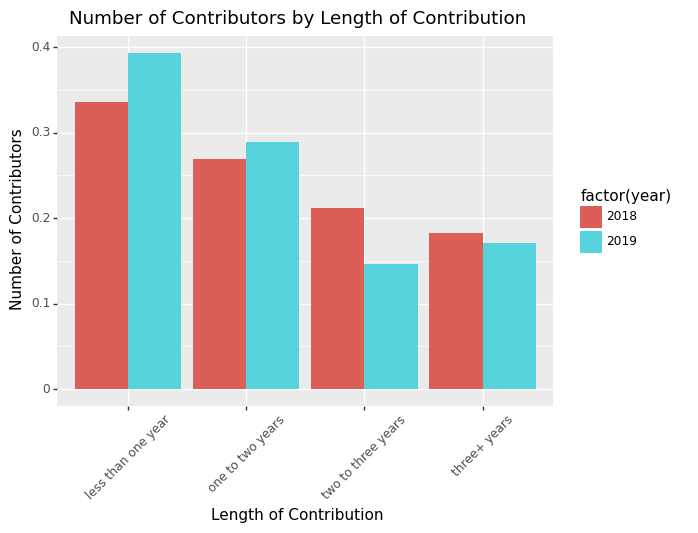

<ggplot: (-9223372029846310133)>

In [6]:
(
    p9.ggplot(
        length_percents,
        p9.aes(x="Contributing_Length", fill="factor(year)", y="percent"),
    )
    + p9.geom_bar(position="dodge", stat="identity")
    + p9.theme(axis_text_x=p9.element_text(angle=45))
    + p9.scale_x_discrete(
        limits=[
            "less than one year",
            "one to two years",
            "two to three years",
            "three+ years",
        ]
    )
    + p9.ggtitle("Number of Contributors by Length of Contribution")
    + p9.xlab("Length of Contribution")
    + p9.ylab("Number of Contributors")
)

As expected, due to the advertisement of the survey on Twitter, a higher proportion of respondents are newer contributors this year.

In [7]:
level_year_totals = survey_data[survey_data['Level_of_Contributor'].notnull()].groupby(['year']).count()['Collector_ID'].reset_index()
level_counts = survey_data.groupby(['Level_of_Contributor','year']).count()['Collector_ID'].reset_index()
level_percents = level_counts.merge(level_year_totals,on='year')
level_percents = level_percents.assign(percent = level_percents['Collector_ID_x']/level_percents['Collector_ID_y'])



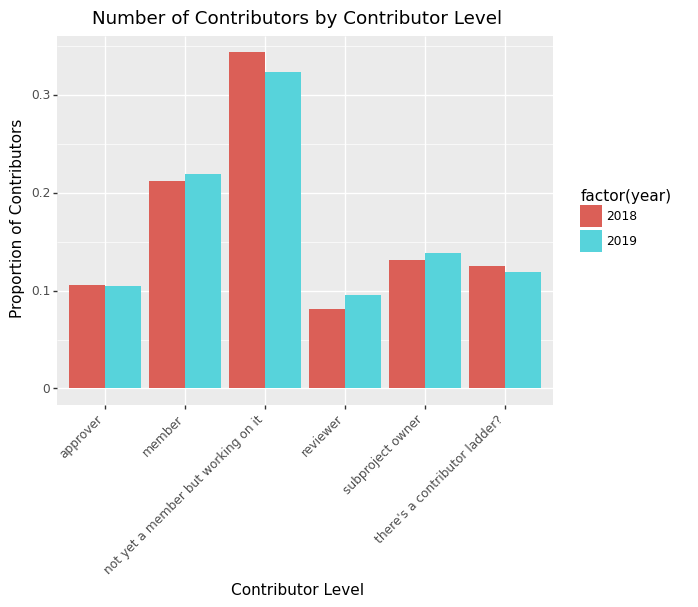

<ggplot: (-9223372036582018763)>

In [8]:
(
    p9.ggplot(
        level_percents,
        p9.aes(x="Level_of_Contributor", fill="factor(year)", y="percent"),
    )
    + p9.geom_bar(position="dodge", stat="identity")
    + p9.theme(axis_text_x=p9.element_text(angle=45, ha="right"))
    + p9.ggtitle("Number of Contributors by Contributor Level")
    + p9.xlab("Contributor Level")
    + p9.ylab("Proportion of Contributors")
)

A larger proportion of respondents this year are in higher roles in the contributor ladder. It appears most of these are due to the smaller proportion of respondents who are not a member for one reason or another.

In [9]:
oss_counts = (
    survey_data.groupby(["year", "Contribute_to_other_OSS"])
    .count()["Collector_ID"]
    .reset_index()
)
oss_year_totals = (
    survey_data[survey_data["Contribute_to_other_OSS"].notnull()]
    .groupby(["year"])
    .count()["Collector_ID"]
    .reset_index()
)

oss_percents = oss_counts.merge(oss_year_totals, on="year")
oss_percents = oss_percents.assign(
    percent=oss_percents["Collector_ID_x"] / oss_percents["Collector_ID_y"]
)

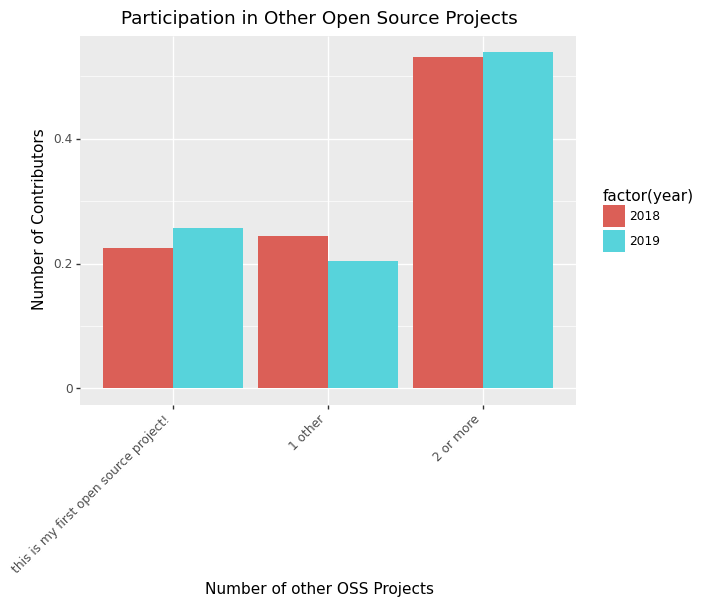

<ggplot: (7008515115)>

In [10]:
(
    p9.ggplot(
        oss_percents,
        p9.aes(x="Contribute_to_other_OSS", fill="factor(year)", y="percent"),
    )
    + p9.geom_bar(position="dodge", stat="identity")
    + p9.theme(axis_text_x=p9.element_text(angle=45, ha="right"))
    + p9.scale_x_discrete(
        limits=["this is my first open source project!", "1 other", "2 or more"]
    )
    + p9.ggtitle("Participation in Other Open Source Projects")
    + p9.xlab("Number of other OSS Projects")
    + p9.ylab("Number of Contributors")
)

There is a small increase in the proportion of contributors for whom Kuberetes is their first open source project. Because the change is so small, no major changes should be based on this finding.

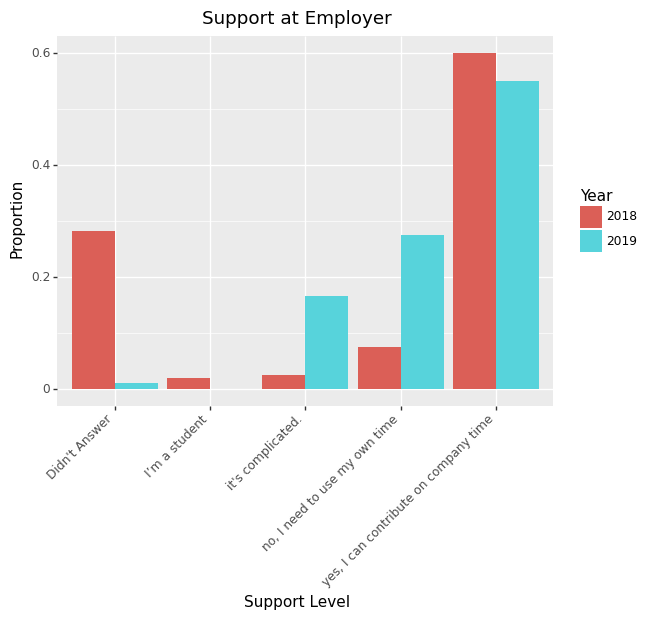

<ggplot: (7008560420)>

In [11]:
counts = survey_data.groupby(["Upstream_supported_at_employer", "year"]).count()[
    "Respondent_ID"
]

total = survey_data.groupby(["year"]).count()["Respondent_ID"]

employee_percents = (
    counts.to_frame().reset_index().merge(total.to_frame().reset_index(), on="year")
)

employee_percents = employee_percents.assign(
    percent=employee_percents["Respondent_ID_x"] / employee_percents["Respondent_ID_y"]
)

(
    p9.ggplot(
        employee_percents,
        p9.aes(x="Upstream_supported_at_employer", fill="factor(year)", y="percent"),
    )
    + p9.geom_bar(position=p9.position_dodge(preserve="single"), stat="identity")
    + p9.labs(
        title="Support at Employer", fill="Year", y="Proportion", x="Support Level"
    )
    + p9.theme(axis_text_x=p9.element_text(angle=45, ha="right"))
)

This question was a required question in 2019 but not in 2018. In addition, the student option was not present in this year's survey. Nonetheless, the proportion of contributors supported by their employer dropped slightly this year. It is difficult to make any conclusions due to the change in the question, but this is a trend to keep a close eye on in future surveys.

## Cross-tabulations

In [12]:
pd.crosstab(
    survey_data.World_Region, [survey_data.Level_of_Contributor, survey_data.year]
)

Level_of_Contributor approver      member       \
year                     2018 2019   2018 2019   
World_Region                                     
Africa                      0    0      0    2   
Asia                        2    2      4    5   
Europe                      5    8     11   15   
North America              10   12     19   22   
Oceania                     0    0      0    1   
South America               0    0      0    1   

Level_of_Contributor not yet a member but working on it      reviewer       \
year                                               2018 2019     2018 2019   
World_Region                                                                 
Africa                                                0    2        0    0   
Asia                                                  8   15        3    5   
Europe                                               21   23        2    9   
North America                                        26   27        8    5   
Oceania                                               0    1        0    1   
South America                                         0    0        0    0   

Level_of_Contributor subproject owner      there's a contributor ladder?       
year                             2018 2019                          2018 2019  
World_Region                                                                   
Africa                              0    0                             0    0  
Asia                                2    0                             1    3  
Europe                              2    6                             4   10  
North America                      16   22                            14   11  
Oceania                             0    0                             0    1  
South America                       1    1                             1    0

In [13]:
pd.crosstab(
    survey_data.Contributing_Length,
    [survey_data.Level_of_Contributor, survey_data.year],
).loc[["less than one year", "one to two years", "two to three years", "three+ years"]]

Level_of_Contributor approver      member       \
year                     2018 2019   2018 2019   
Contributing_Length                              
less than one year          0    3      1   15   
one to two years            2    8     10   19   
two to three years          3    6      6    5   
three+ years                9    5      0    7   

Level_of_Contributor not yet a member but working on it      reviewer       \
year                                               2018 2019     2018 2019   
Contributing_Length                                                          
less than one year                                   24   42        1    4   
one to two years                                      1   18        5    7   
two to three years                                    4    6        2    4   
three+ years                                          0    2        0    5   

Level_of_Contributor subproject owner      there's a contributor ladder?       
year                             2018 2019                          2018 2019  
Contributing_Length                                                            
less than one year                  0    0                             9   18  
one to two years                    5    5                             5    4  
two to three years                  7    8                             0    2  
three+ years                        9   16                             1    1

In [14]:
pd.crosstab(
    survey_data.Contributing_Length,
    [survey_data.Contribute_to_other_OSS, survey_data.year],
).loc[
    ["less than one year", "one to two years", "two to three years", "three+ years"],
    ["this is my first open source project!", "1 other", "2 or more"],
]

Contribute_to_other_OSS 1 other      2 or more       \
year                       2018 2019      2018 2019   
Contributing_Length                                   
less than one year            9   16        12   39   
one to two years              7   13        15   33   
two to three years            5    6        15   17   
three+ years                  3    8        14   24   

Contribute_to_other_OSS this is my first open source project!       
year                                                     2018 2019  
Contributing_Length                                                 
less than one year                                         14   27  
one to two years                                            6   15  
two to three years                                          2    8  
three+ years                                                2    4

In [15]:
pd.crosstab(
    survey_data.Level_of_Contributor,
    [survey_data.Upstream_supported_at_employer, survey_data.year],
)

Upstream_supported_at_employer     Didn't Answer      I’m a student  \
year                                        2018 2019          2018   
Level_of_Contributor                                                  
approver                                       3    0             0   
member                                         9    0             1   
not yet a member but working on it            22    0             1   
reviewer                                       0    0             1   
subproject owner                               3    0             0   
there's a contributor ladder?                  8    1             0   

Upstream_supported_at_employer     it's complicated.       \
year                                            2018 2019   
Level_of_Contributor                                        
approver                                           1    5   
member                                             0   11   
not yet a member but working on it                 1   10   
reviewer                                           0    4   
subproject owner                                   0    5   
there's a contributor ladder?                      2    0   

Upstream_supported_at_employer     no, I need to use my own time       \
year                                                        2018 2019   
Level_of_Contributor                                                    
approver                                                       0    3   
member                                                         4   13   
not yet a member but working on it                             4   26   
reviewer                                                       2    5   
subproject owner                                               0    1   
there's a contributor ladder?                                  2   10   

Upstream_supported_at_employer     yes, I can contribute on company time       
year                                                                2018 2019  
Level_of_Contributor                                                           
approver                                                              13   14  
member                                                                20   22  
not yet a member but working on it                                    27   32  
reviewer                                                              10   11  
subproject owner                                                      18   23  
there's a contributor ladder?                                          8   14

In [16]:
pd.crosstab(
    survey_data.Contributing_Length,
    [survey_data.Upstream_supported_at_employer, survey_data.year],
)

Upstream_supported_at_employer Didn't Answer      I’m a student  \
year                                    2018 2019          2018   
Contributing_Length                                               
less than one year                        18    2             1   
one to two years                           2    0             2   
three+ years                               4    0             0   
two to three years                         6    0             0   

Upstream_supported_at_employer it's complicated.       \
year                                        2018 2019   
Contributing_Length                                     
less than one year                             1   10   
one to two years                               0   12   
three+ years                                   0    5   
two to three years                             0    8   

Upstream_supported_at_employer no, I need to use my own time       \
year                                                    2018 2019   
Contributing_Length                                                 
less than one year                                         6   37   
one to two years                                           2   16   
three+ years                                               0    4   
two to three years                                         1    1   

Upstream_supported_at_employer yes, I can contribute on company time       
year                                                            2018 2019  
Contributing_Length                                                        
less than one year                                                 9   34  
one to two years                                                  22   33  
three+ years                                                      15   27  
two to three years                                                15   22

In [17]:
pd.crosstab(
    survey_data.Interested_in_next_level,
    [survey_data.Level_of_Contributor, survey_data.year],
)

Level_of_Contributor                               approver      member       \
year                                                   2018 2019   2018 2019   
Interested_in_next_level                                                       
if I had help/mentoring/support                           2    1      8   13   
if I had more free time                                   4    8      9    8   
no                                                        2    1      3    3   
no, already a subproject owner (highest level o...        5    0      1    0   
yes                                                       4   11     13   22   

Level_of_Contributor                               not yet a member but working on it  \
year                                                                             2018   
Interested_in_next_level                                                                
if I had help/mentoring/support                                                    31   
if I had more free time                                                            12   
no                                                                                  2   
no, already a subproject owner (highest level o...                                  0   
yes                                                                                10   

Level_of_Contributor                                    reviewer       \
year                                               2019     2018 2019   
Interested_in_next_level                                                
if I had help/mentoring/support                      18        4    3   
if I had more free time                              13        2    3   
no                                                    3        2    0   
no, already a subproject owner (highest level o...    0        0    0   
yes                                                  34        5   14   

Level_of_Contributor                               subproject owner       \
year                                                           2018 2019   
Interested_in_next_level                                                   
if I had help/mentoring/support                                   2    0   
if I had more free time                                           3    4   
no                                                                0    0   
no, already a subproject owner (highest level o...               13   25   
yes                                                               3    0   

Level_of_Contributor                               there's a contributor ladder?  \
year                                                                        2018   
Interested_in_next_level                                                           
if I had help/mentoring/support                                                6   
if I had more free time                                                        8   
no                                                                             4   
no, already a subproject owner (highest level o...                             0   
yes                                                                            2   

Level_of_Contributor                                     
year                                               2019  
Interested_in_next_level                                 
if I had help/mentoring/support                       3  
if I had more free time                               6  
no                                                    2  
no, already a subproject owner (highest level o...    0  
yes                                                  14

## Challenges/Blockers Faced

In [18]:
blocker_ratings = ["A frequent blocker",'Often a problem','Sometimes a problem','Rarely a problem','Not a problem']


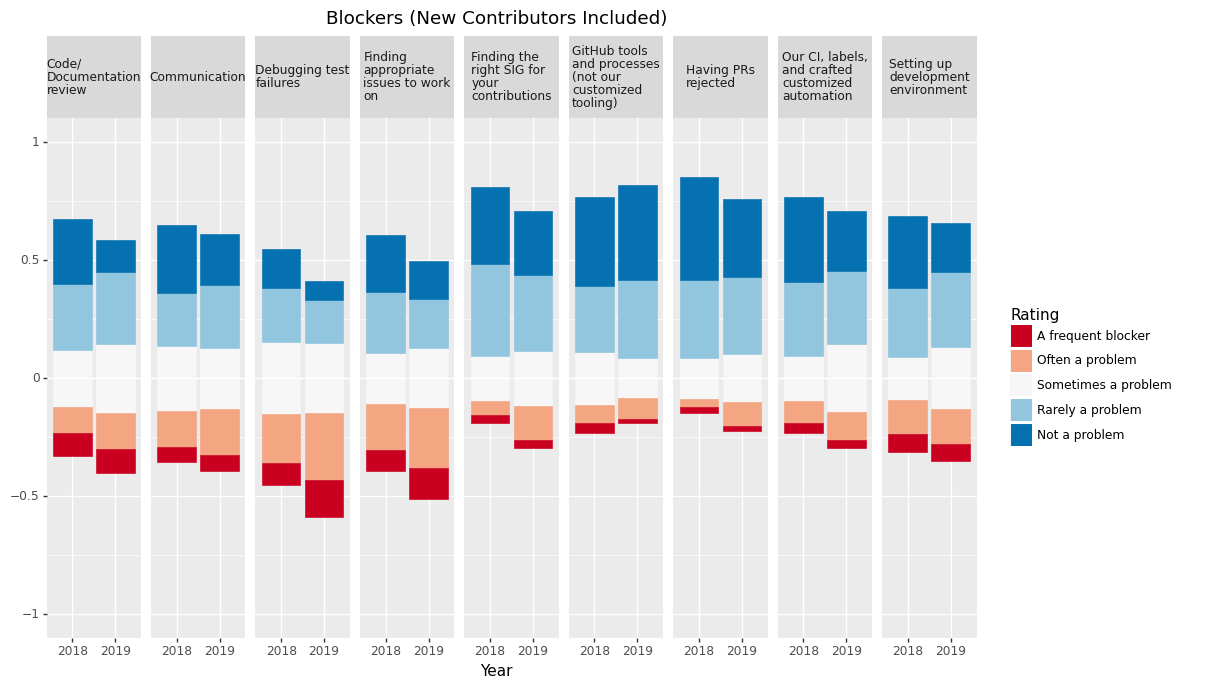

<ggplot: (7009222895)>

In [19]:
(
    make_likert_chart_multi_year(survey_data, "Blocker:", blocker_ratings)
    + p9.labs(
        x="Year",
        y="",
        fill="Rating",
        color="Rating",
        title="Blockers (New Contributors Included)",
    )
    + p9.theme(
        legend_margin=5,
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
    )
    + p9.ylim(-1, 1)
)

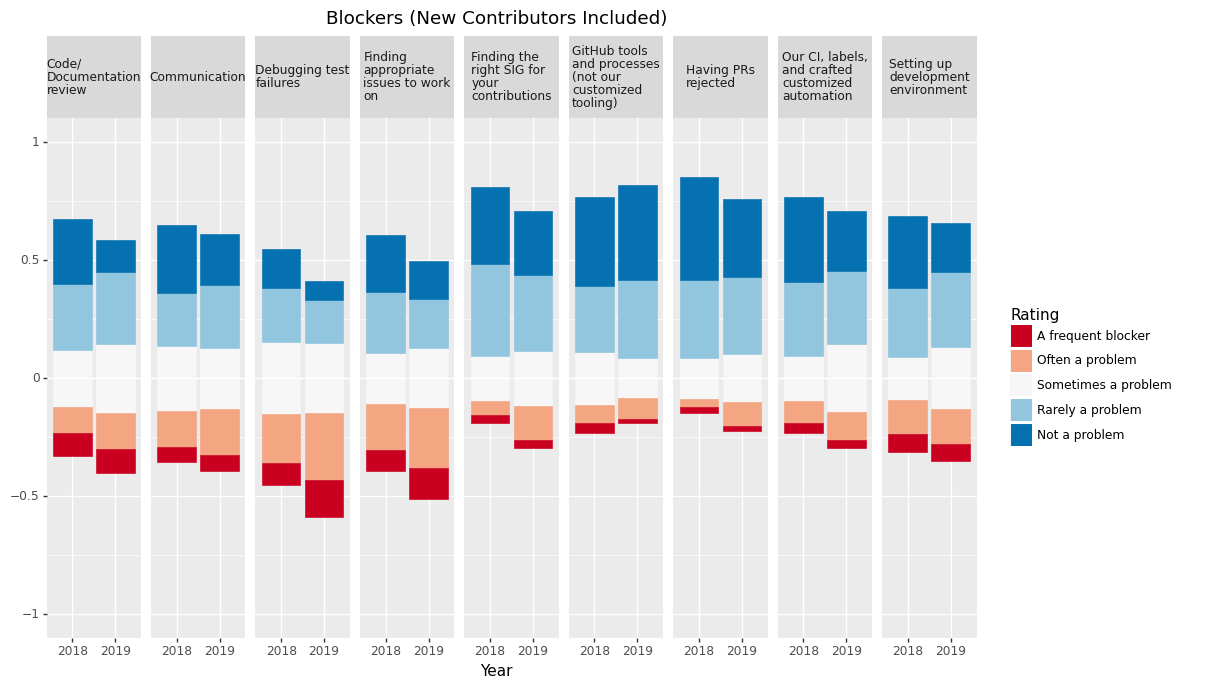

<ggplot: (-9223372029846058748)>

In [20]:
(
    make_likert_chart_multi_year(survey_data, "Blocker:", blocker_ratings)
    + p9.labs(
        x="Year",
        y="",
        fill="Rating",
        color="Rating",
        title="Blockers (New Contributors Included)",
    )
    + p9.theme(
        legend_margin=5,
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
    )
    + p9.ylim(-1, 1)
)

Respondents across the board reported feeling more blocked this past year than in 2018. The only exception is GitHub tooling. To ensure this was not due to a higher proportion of new contributors we looked at the data without them. This is show below.

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)


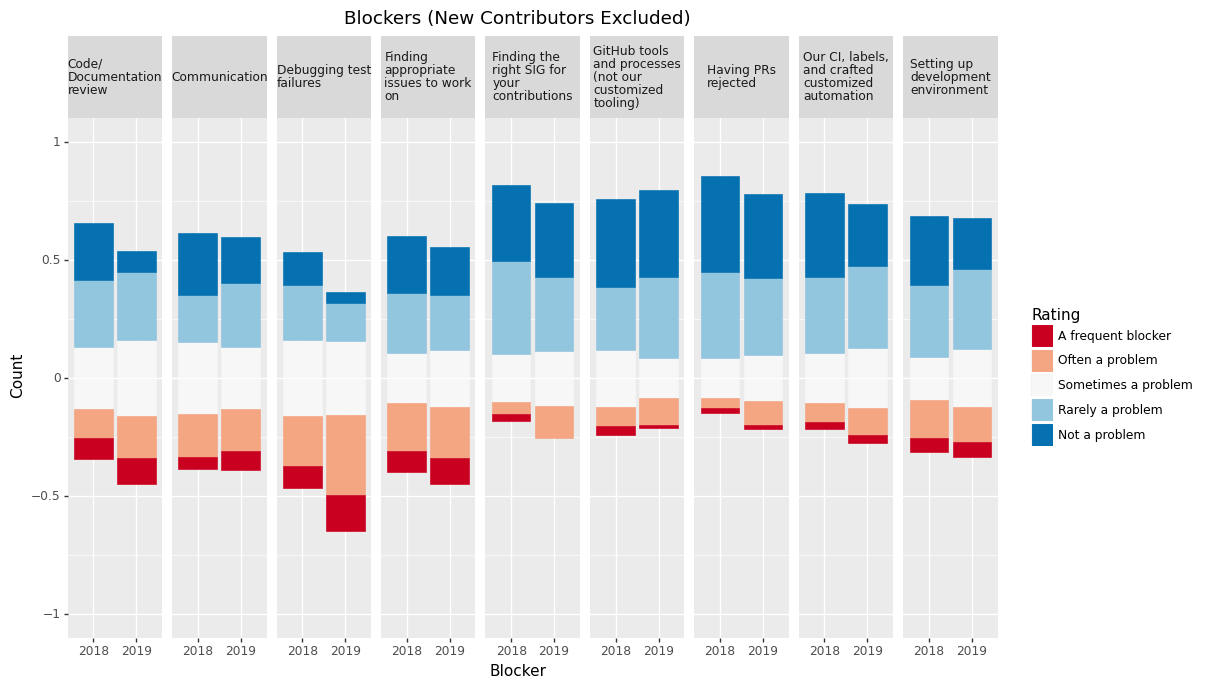

<ggplot: (-9223372029844506543)>

In [21]:
(
    make_likert_chart_multi_year(
        survey_data, "Blocker:", blocker_ratings, exclude_new_contributors=True
    )
    + p9.labs(
        x="Blocker",
        y="Count",
        fill="Rating",
        color="Rating",
        title="Blockers (New Contributors Excluded)",
    )
    + p9.theme(
        legend_margin=5,
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
    )
    + p9.ylim(-1, 1)
)

After removing contributors who reported having being involved for less than a year, the overall trend holds. One concern in comparing these two datasets is that this year respondents were asked how challenging these areas were, not how much they are blocked by them. Consistent wording will make these more comparable between future surveys. 

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 20 rows containing missing values.
  data = self.position.setup_data(self.data, params)


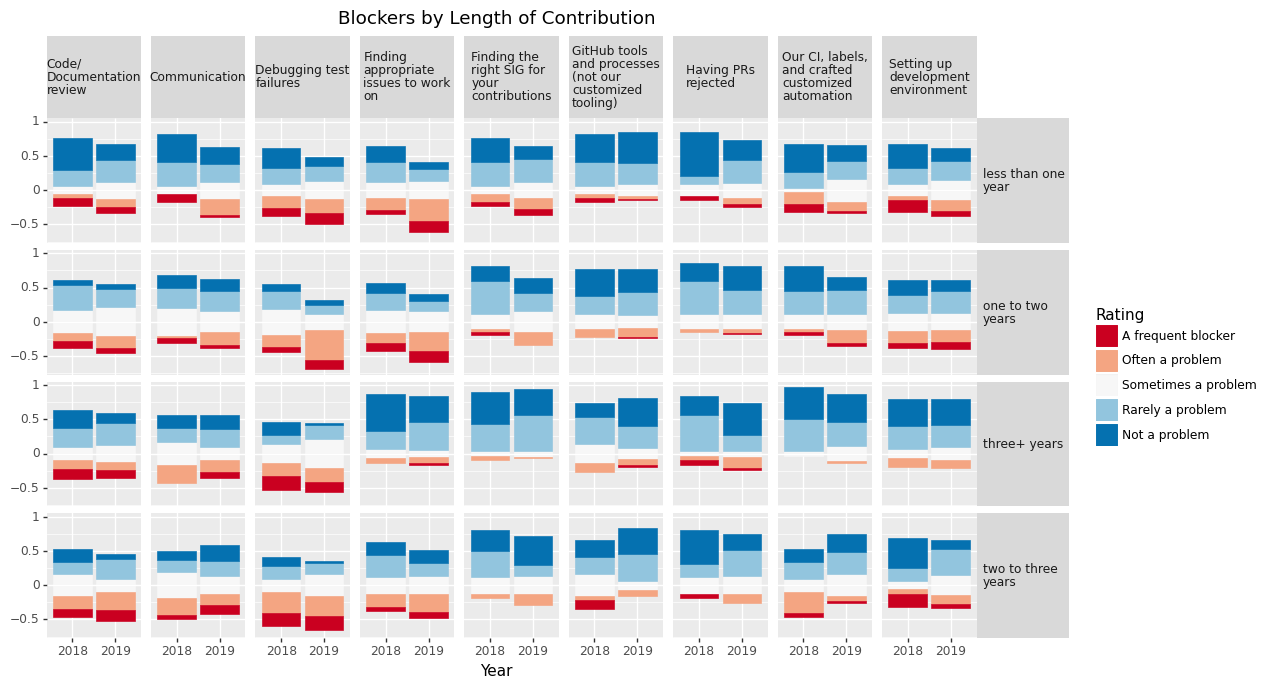

<ggplot: (-9223372029843960383)>

In [22]:
(
    make_likert_chart_multi_year(
        survey_data, "Blocker:", blocker_ratings, ["Contributing_Length", "."]
    )
    + p9.labs(
        x="Year",
        y="",
        fill="Rating",
        color="Rating",
        title="Blockers by Length of Contribution",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.8, "units": "in"}),
    )
)

Contributors who have been contributing for two years or more are more rate the areas as being as difficult or slightly less of an issue than in 2018. The trend is reversed for contributors with less than two years of experience. They rate items as being more difficult in 2019, suggesting potential for outreach and improvement among this group.

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 7 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 38 rows containing missing values.
  data = self.position.setup_data(self.data, params)


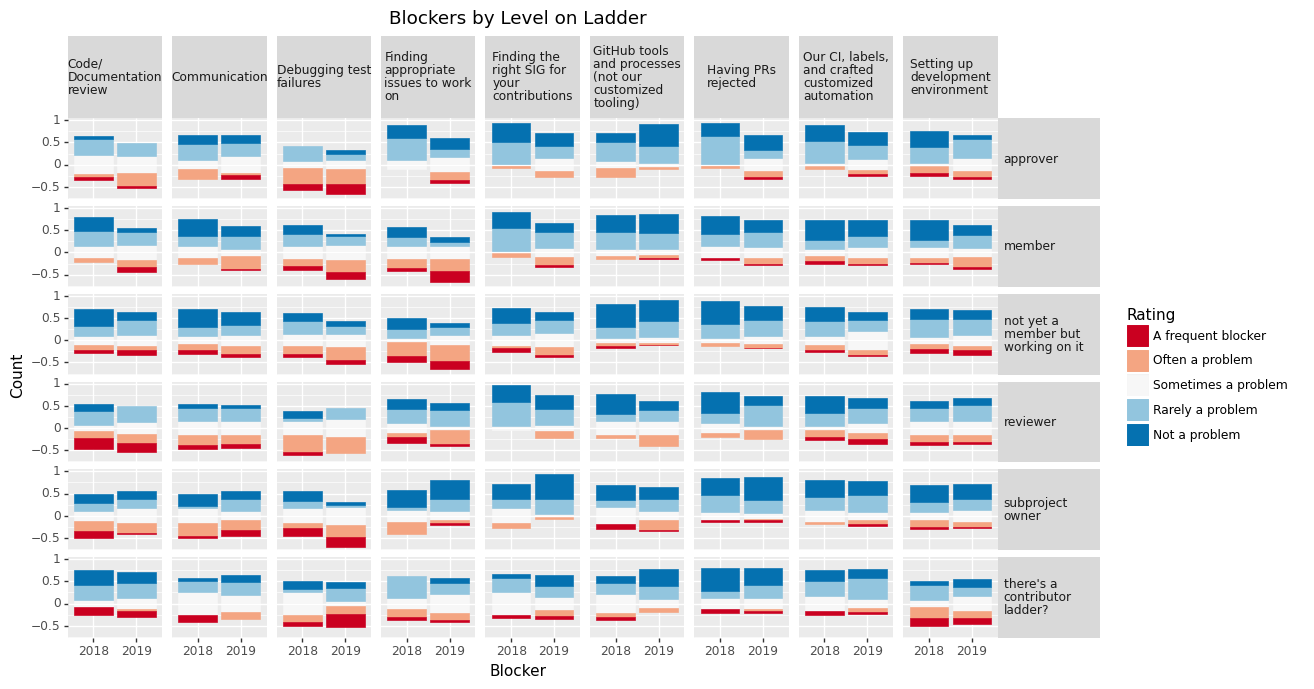

<ggplot: (7009431777)>

In [23]:
(
    make_likert_chart_multi_year(
        survey_data, "Blocker:", blocker_ratings, ["Level_of_Contributor", "."]
    )
    + p9.labs(
        x="Blocker",
        y="Count",
        fill="Rating",
        color="Rating",
        title="Blockers by Level on Ladder",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

Subproject owners report less challenges in 2019 than in 2018. This is contrast to other cohorts whose challenges have increased or stayed level. This is especially clear in the columns for finding the right SIG, and code/documentation review to a lesser extent.

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 3 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 39 rows containing missing values.
  data = self.position.setup_data(self.data, params)


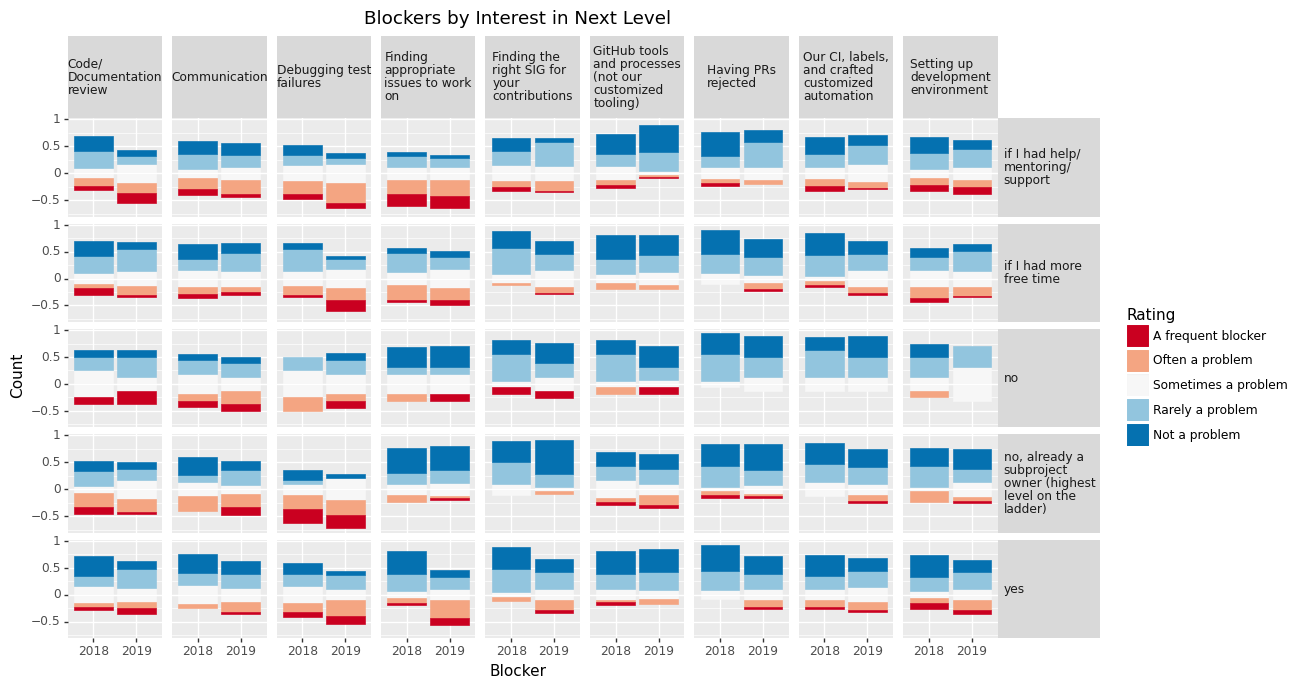

<ggplot: (7009992810)>

In [24]:
(
    make_likert_chart_multi_year(
        survey_data, "Blocker:", blocker_ratings, ["Interested_in_next_level", "."]
    )
    + p9.labs(
        x="Blocker",
        y="Count",
        fill="Rating",
        color="Rating",
        title="Blockers by Interest in Next Level",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

This plot shows an interesting difference between contributors interested in the next level not conditional on support, and those whose interest is conditioned on further support. In contrast to what we would expect, those who are interested irrespective of the support available report more challenges in 2019 than in 2018 with finding issues to work on and finding the right SIG. Combining this finding with the cross tabulation above showing contributors across the spectrum responding more with unconditional interest suggests several things. One is that what the mentoring program is and how it could help may need more publication. The other may be that there is a sense of pride in not needing mentoring, and so finding a way to break down that stigma may lead to happier contributors in the long run.

## Sources Checked for News

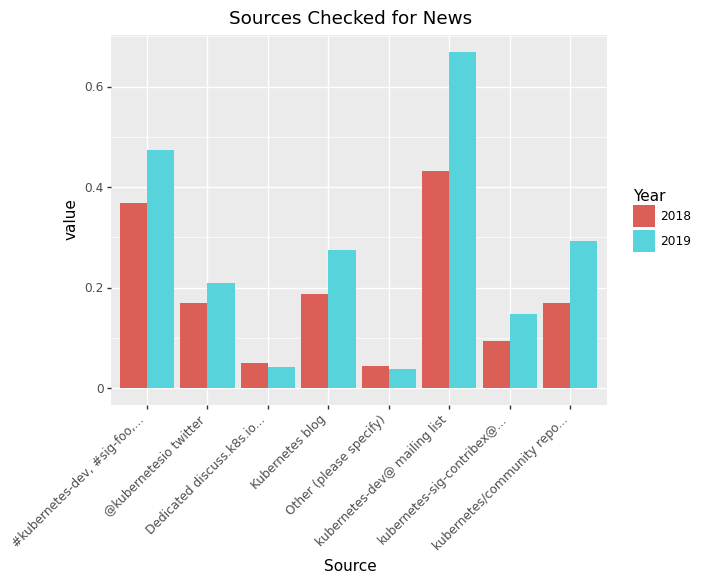

<ggplot: (-9223372029846187341)>

In [25]:
make_bar_chart_multi_year(survey_data, "Check_for_news:") + p9.labs(
    title="Sources Checked for News", fill="Year", x="Source"
)

This question does not require users to choose only one option, so the proportions add up to more than 1. Most news sources see an increase in use. The largest jump is the kubernetes-dev mailing list, with over 60% of respondents checking the mailing list. 

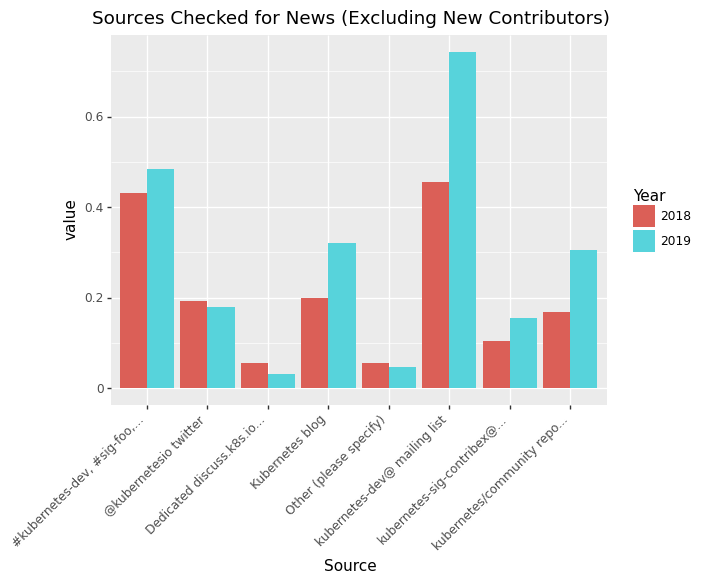

<ggplot: (7008732308)>

In [26]:
make_bar_chart_multi_year(
    survey_data, "Check_for_news:", exclude_new_contributors=True
) + p9.labs(
    title="Sources Checked for News (Excluding New Contributors)",
    fill="Year",
    x="Source",
)

After excluding newer contributors, an even larger percent of contributors get their news from the mailing list, suggesting it is important for new users to be introduced to the mailing list. The other change from the previous plot is that the use of Twitter now shows a downward trend from 2018 to 2019. This confirms that advertising the survey on Twitter may have skewed the results slightly. 

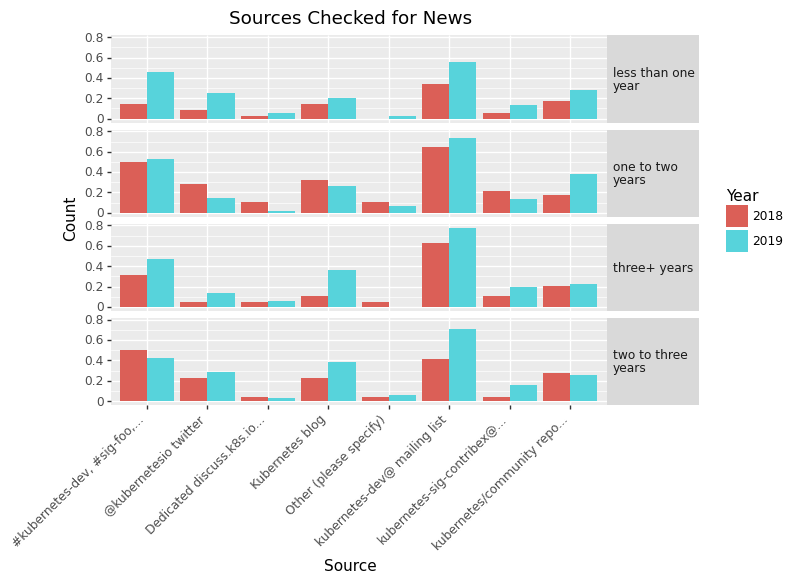

<ggplot: (-9223372029841857322)>

In [27]:
(
    make_bar_chart_multi_year(
        survey_data, "Check_for_news:", facet_by=[".", "Contributing_Length"]
    )
    + p9.theme(strip_text_y=p9.element_text(margin={"r": 0.8, "units": "in"}))
    + p9.labs(title="Sources Checked for News", fill="Year", x="Source", y="Count")
)

In addition to the large increase in the use of Twitter by new contributors, there are a few other changes in new consumption in relation to the length of participation in Kubernetes. The proportion of new contributors using Slack has increased greatly. There is a consistent pattern across contributors who have been involved for one to two years, with many of the resources seeing decreased use. It is not clear why this is, but it not a large concern, as the most widely used resources are the same among all groups: the mailing list, Slack, and the blog. 

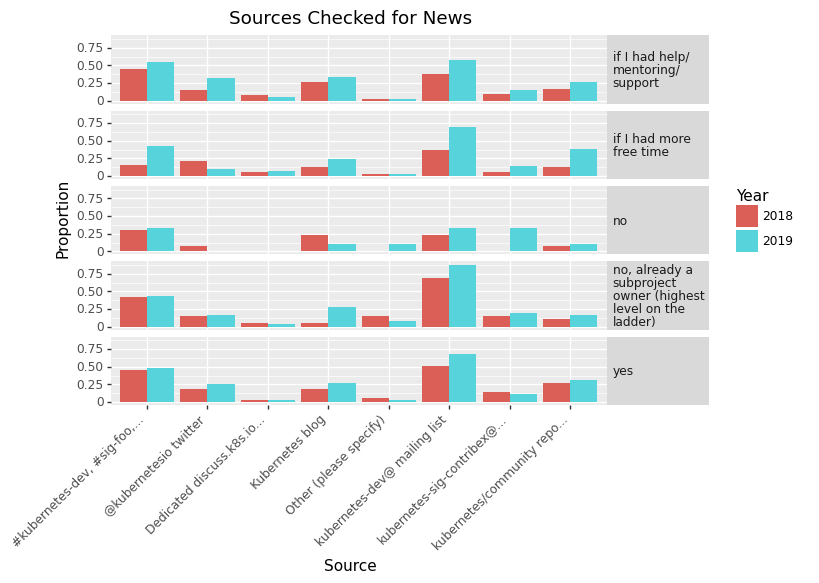

<ggplot: (7013039550)>

In [28]:
(
    make_bar_chart_multi_year(
        survey_data, "Check_for_news:", facet_by=[".", "Interested_in_next_level"]
    )
    + p9.theme(strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}))
    + p9.labs(title="Sources Checked for News", fill="Year", x="Source", y="Proportion")
)

## Resource Usage

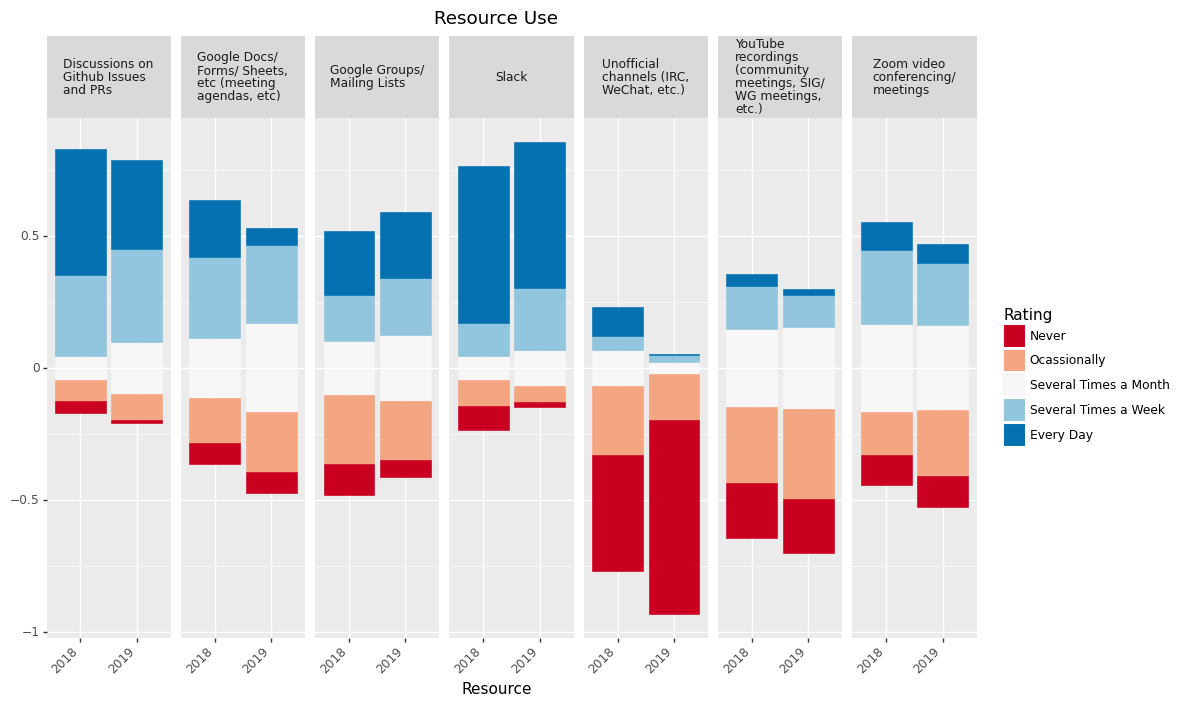

<ggplot: (-9223372029844479898)>

In [29]:
use_ratings = [
    "Every Day",
    "Several Times a Week",
    "Several Times a Month",
    "Ocassionally",
    "Never",
]
use_ratings.reverse()
(
    make_likert_chart_multi_year(
        survey_data, "Use_freq:", use_ratings, five_is_high=True
    )
    + p9.labs(x="Resource", y="", fill="Rating", color="Rating", title="Resource Use")
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

The frequency of use across communication channels has fallen from 2018 to 2019 for most options. The only two with a positive trend are Slack and Google Groups/Mailing List. GitHub discussions saw a slight decrease, but is still a very heavily used tool. The decrease is due to the higher number of new contributors as shown in the plot below.

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)


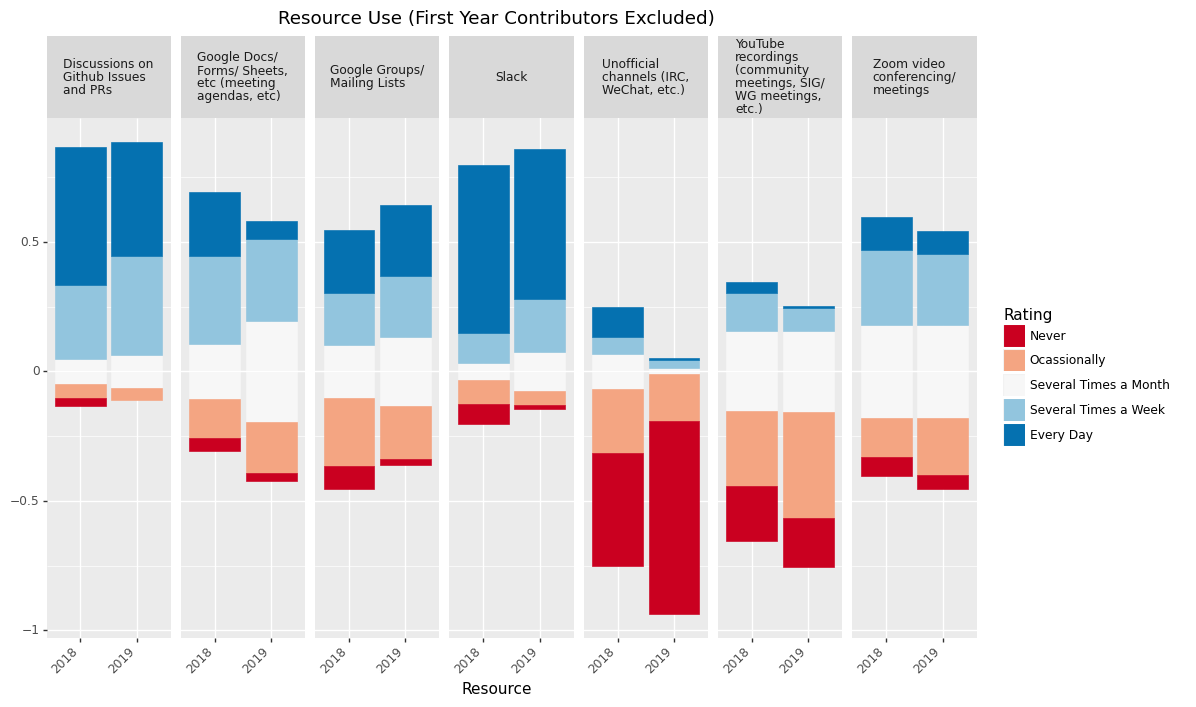

<ggplot: (-9223372029844137314)>

In [30]:
use_ratings = [
    "Every Day",
    "Several Times a Week",
    "Several Times a Month",
    "Ocassionally",
    "Never",
]
use_ratings.reverse()
(
    make_likert_chart_multi_year(
        survey_data,
        "Use_freq:",
        use_ratings,
        five_is_high=True,
        exclude_new_contributors=True,
    )
    + p9.labs(
        x="Resource",
        y="",
        fill="Rating",
        color="Rating",
        title="Resource Use (First Year Contributors Excluded)",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

After excluding contributors with less than one year of experience, GitHub use no longer decreases. With this smaller data, we can see that out of all options and all respondents in 2018 and 2019, the use of GitHub in 2019 is the only resource to have no contributors report they never used the service.

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 30 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 44 rows containing missing values.
  data = self.position.setup_data(self.data, params)


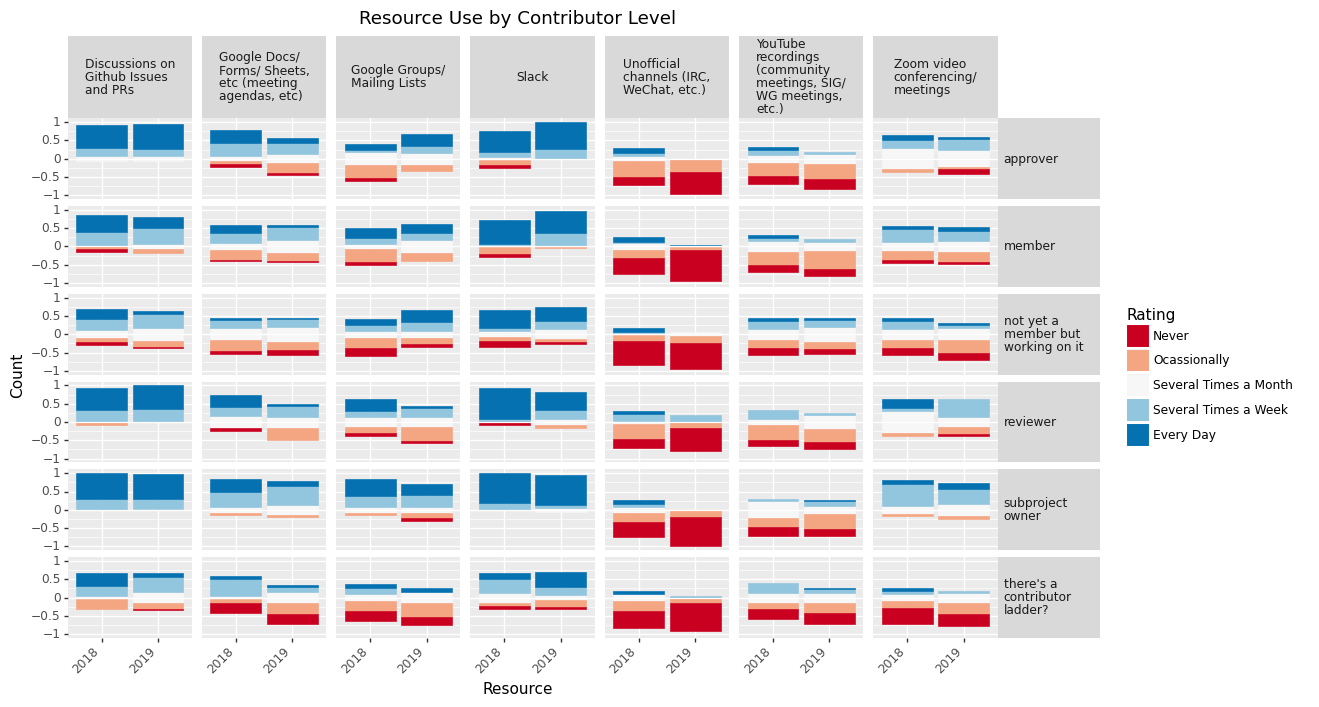

<ggplot: (7009403533)>

In [31]:
(
    make_likert_chart_multi_year(
        survey_data,
        "Use_freq:",
        use_ratings,
        facet_by=["Level_of_Contributor", "."],
        five_is_high=True,
    )
    + p9.labs(
        x="Resource",
        y="Count",
        fill="Rating",
        color="Rating",
        title="Resource Use by Contributor Level",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_x=p9.element_text(
            margin={"t": 0.35, "b": 0.35, "l": 1, "r": 1, "units": "in"}
        ),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

Most trends are consistent across levels of the contributor ladder. The one exception is that subproject owners, and especially reviewers, used the mailing list and Google Groups less frequently in 2019 than in 2018.

## Contribution Areas

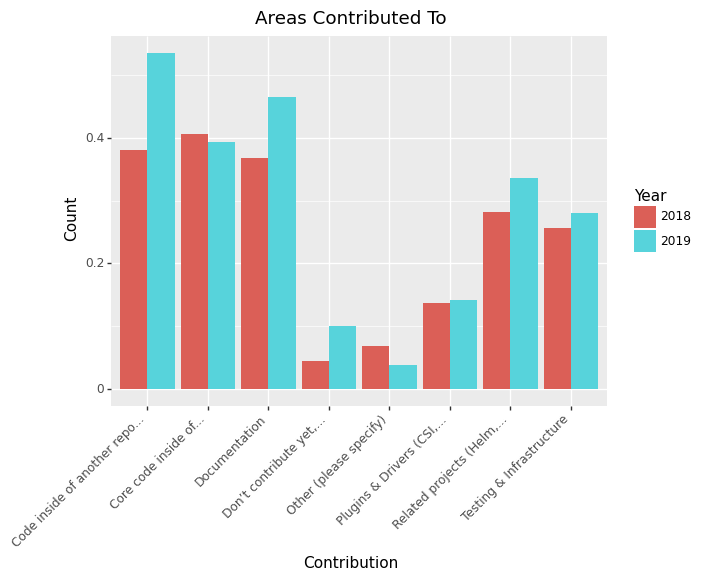

<ggplot: (7008743544)>

In [32]:
(
    make_bar_chart_multi_year(survey_data, "Contribute:")
    + p9.labs(x="Contribution", y="Count", title="Areas Contributed To", fill="Year")
)

Most areas saw increases in contributors, with the exception of code inside Kubernetes/Kubernetes and other. This reflects the continuing effort to only keep core code in the Kubernetes/Kuberenetes repository, moving other contributions to additional repositories in the Kubernetes organization. 

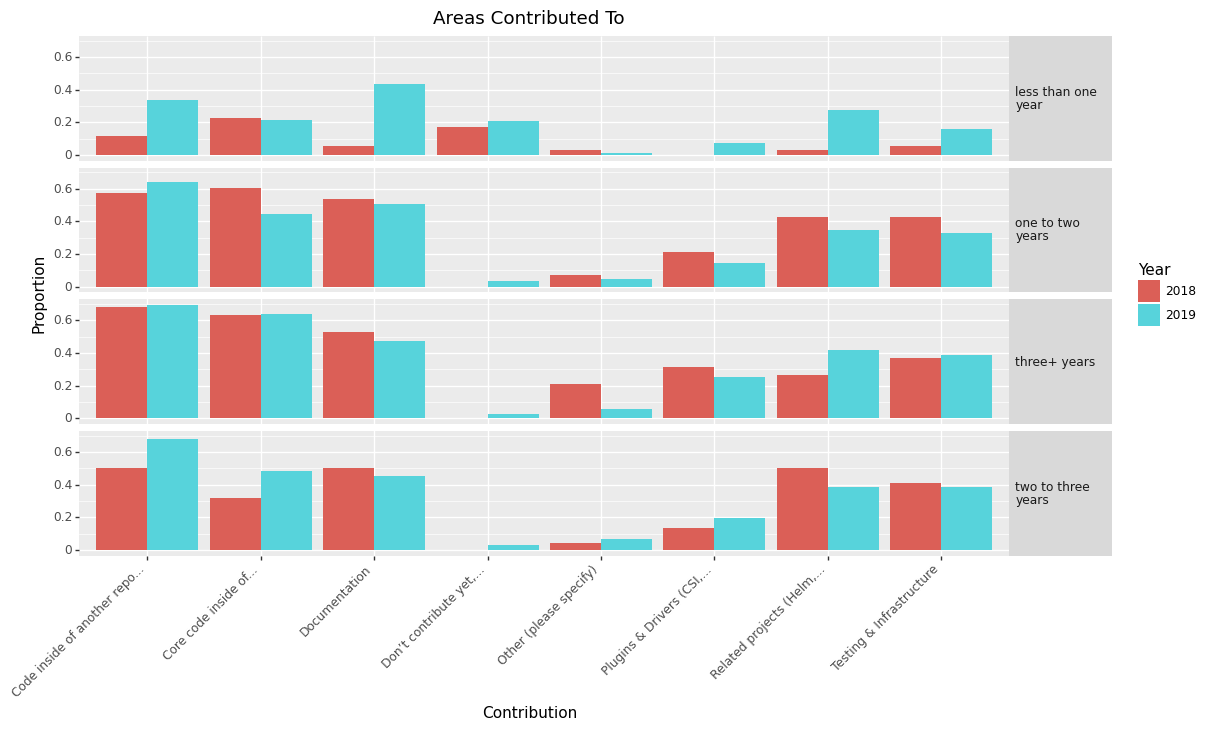

<ggplot: (-9223372029846015039)>

In [33]:
(
    make_bar_chart_multi_year(
        survey_data, "Contribute:", facet_by=["Contributing_Length", "."]
    )
    + p9.labs(
        x="Contribution", y="Proportion", title="Areas Contributed To", fill="Year"
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_y=p9.element_text(margin={"r": 0.9, "units": "in"}),
    )
)

Contributors who have less than one year of experience saw the greatest increase in their contributions. The largest gains were seen in the areas of Documentation and related projects. Other cohorts saw the proportions contributing to documentation slightly decrease. This isn't a bad thing if all necessary documentation is getting done, but a trend to keep an eye on if it falls below the desired standard. 

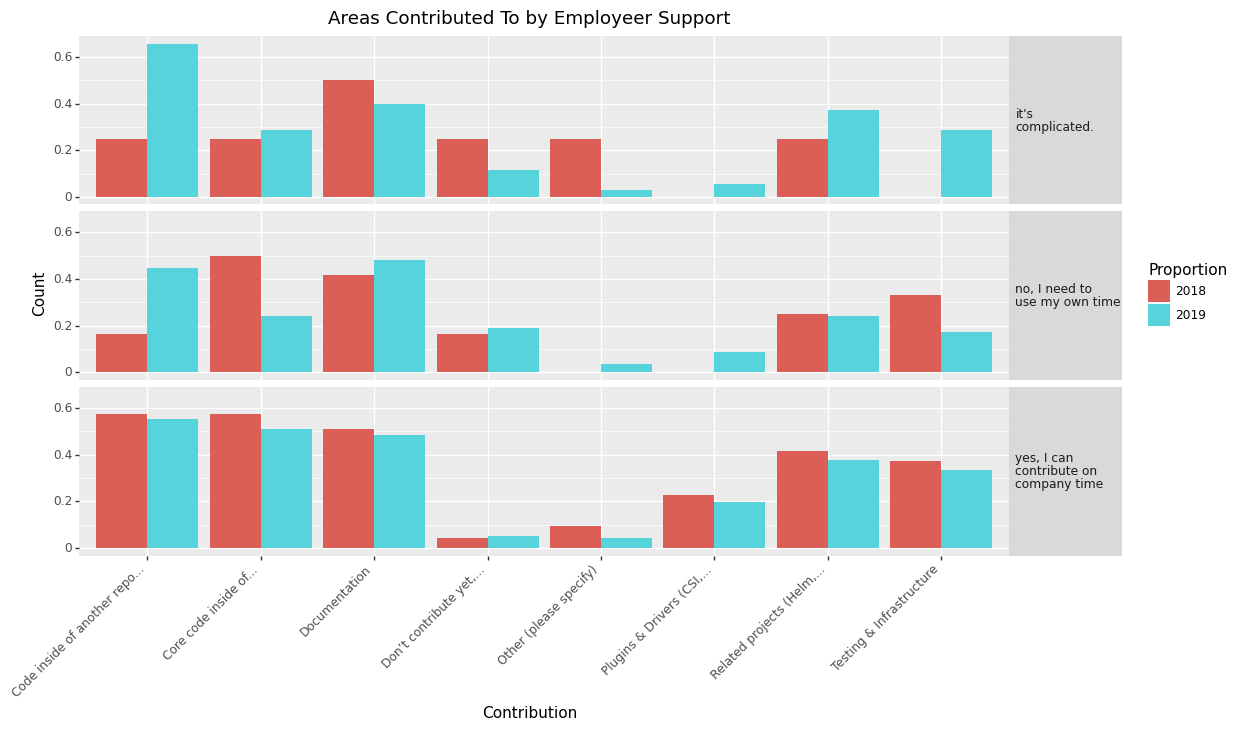

<ggplot: (-9223372029845380748)>

In [34]:
(
    make_bar_chart_multi_year(
        survey_data[
            survey_data.Upstream_supported_at_employer.isin(
                ["Didn't Answer", "I’m a student"]
            )
            == False
        ],
        "Contribute:",
        facet_by=["Upstream_supported_at_employer", "."],
    )
    + p9.labs(
        x="Contribution",
        y="Count",
        title="Areas Contributed To by Employeer Support",
        fill="Proportion",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_y=p9.element_text(margin={"r": 1, "units": "in"}),
    )
)

The plot above shows the proportion of each cohort that contributes to a certain area. A large drop is seen among those who use their own time in their contribution to the core repository. This is matched by an almost equal increase in the same group's contributions to other repositories owned by the Kubernetes project. 

Contributions from those who can use company time decreased in all areas. As contributors can select more than on area, this suggests that each person is contributing to less areas. This is confirmed in the table below.

In [35]:
survey_data.groupby(["Upstream_supported_at_employer", "year"]).apply(
    lambda x: x[x.columns[x.columns.str.startswith("Contribute")]].sum(axis=1).mean()
).reset_index().rename(columns={0: "Average Number of Areas"})

,Upstream_supported_at_employer,year,Average Number of Areas
0,Didn't Answer,2018,0.133333
1,Didn't Answer,2019,0.000000
2,I’m a student,2018,2.000000
3,it's complicated.,2018,1.750000
4,it's complicated.,2019,2.200000
5,"no, I need to use my own time",2018,1.833333
6,"no, I need to use my own time",2019,1.896552
7,"yes, I can contribute on company time",2018,2.812500
8,"yes, I can contribute on company time",2019,2.551724


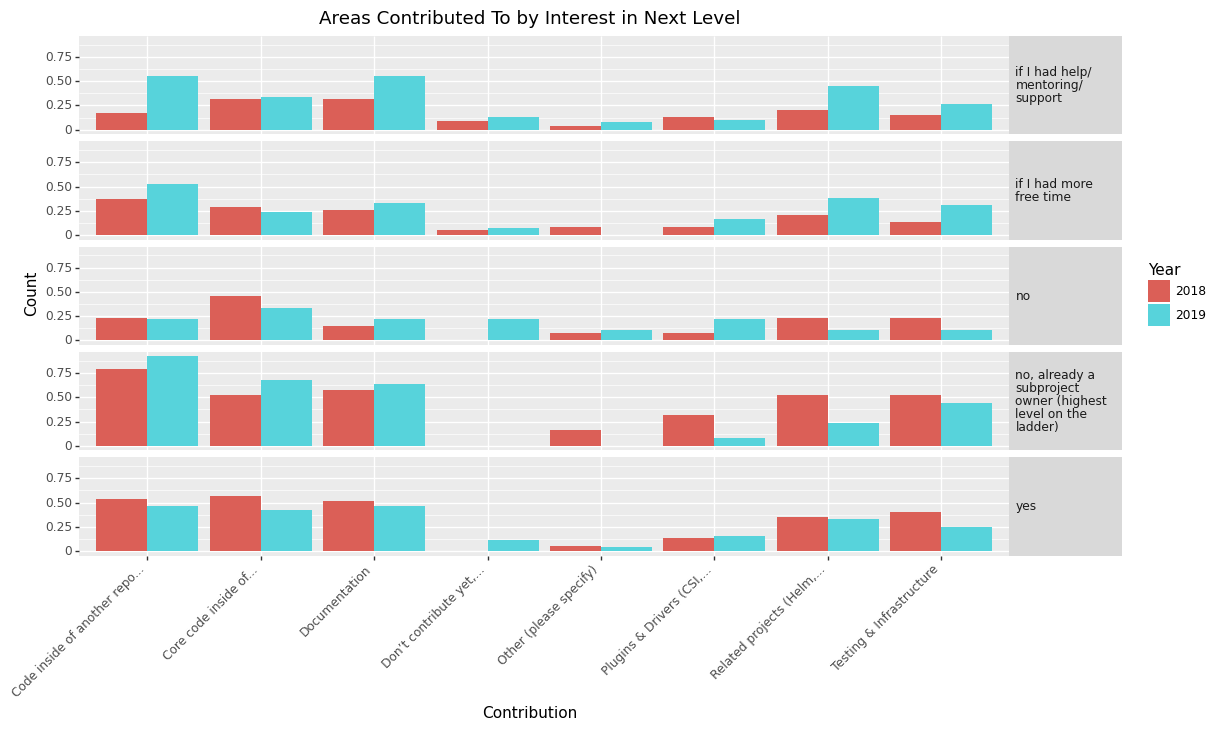

<ggplot: (7011110699)>

In [36]:
(
    make_bar_chart_multi_year(
        survey_data, "Contribute:", facet_by=["Interested_in_next_level", "."]
    )
    + p9.labs(
        x="Contribution",
        y="Count",
        title="Areas Contributed To by Interest in Next Level",
        fill="Year",
    )
    + p9.theme(
        figure_size=(12, (9 / 4) * 3),
        strip_text_y=p9.element_text(margin={"r": 1, "units": "in"}),
    )
)

Core code contributions dropped from 2018 to 2019 among all groups except subproject owners. Those who want support to reach the next level contributed more across all areas. Those who want to move to the next level but do not condition their interest on receiving help contributed less across most areas than in 2018. This again suggests that more clarification is needed around the mentorship program, as many of those who think they need more support contribute widely, while those that don't contribute as much don't feel they need support. 

## Use of Help Wanted and Good First Issue Labels

In [37]:
help_wanted = survey_data[
    survey_data[
        "Do_you_use_the\xa0Help_Wanted_and/or_Good_First_Issue_labels_on_issues_you_file_to_find_contributors"
    ].isna()
    == False
]

In [38]:
help_counts = (
    help_wanted.rename(
        columns={
            "Do_you_use_the\xa0Help_Wanted_and/or_Good_First_Issue_labels_on_issues_you_file_to_find_contributors": "help"
        }
    )
    .groupby(["year", "help"])
    .count()["Collector_ID"]
    .reset_index()
)

In [39]:
help_year_counts = help_counts.groupby("year").sum().reset_index()
help_percents = help_year_counts.merge(help_counts, on="year")

In [40]:
help_percents = help_percents.assign(
    percent=help_percents["Collector_ID_y"] / help_percents["Collector_ID_x"]
)

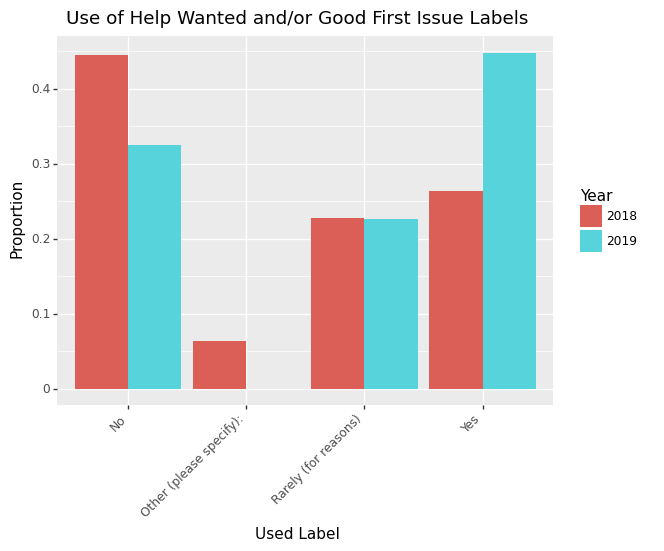

<ggplot: (7010640455)>

In [41]:
help_plot = (
    p9.ggplot(help_percents, p9.aes(x="help", y="percent", fill="factor(year)"))
    + p9.geom_bar(position=p9.position_dodge(preserve="single"), stat="identity")
    + p9.theme(axis_text_x=p9.element_text(angle=45, ha="right"))
    + p9.labs(
        x="Used Label",
        title="Use of Help Wanted and/or Good First Issue Labels",
        y="Proportion",
        fill="Year",
    )
)

help_plot

Use of the help wanted and good first labels clearly increased from 2018 to 2019.